# Disaster Tweets

Neil Chen, University of Colorado Boulder

Mar 30, 2025

Firstly I learned a bit NLP by following this tutorial: <https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial>



In [53]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## Exploratory Data Analysis (EDA)

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
train_df[train_df["target"] == 0]["text"].values[2]

'Summer is lovely'

In [8]:
train_df[train_df["target"] == 1]["text"].values[3]

'13,000 people receive #wildfires evacuation orders in California '

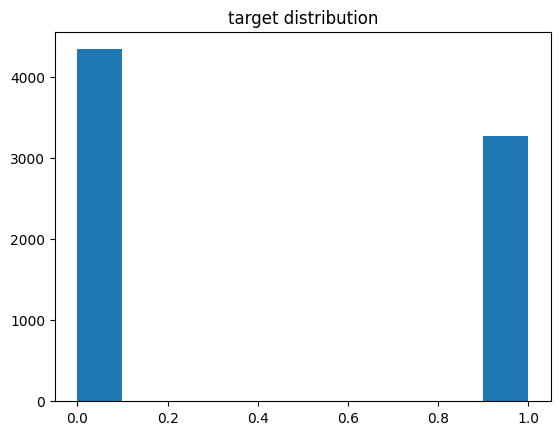

In [23]:
train_df['target'].value_counts(normalize=True)

plt.hist(train_df['target'])
plt.title('target distribution')
plt.show()

Text(0.5, 1.0, 'Top 10 Keywords by Count')

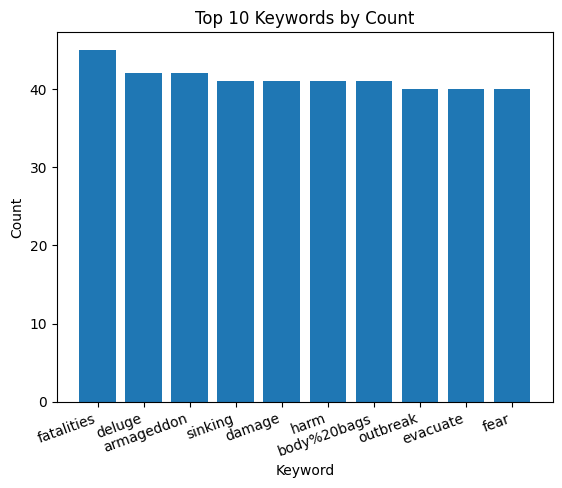

In [45]:
# Check keywords
top_10_keywords = train_df['keyword'].value_counts().head(10)
plt.bar(top_10_keywords.index.tolist(), top_10_keywords.values.tolist())
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Keywords by Count')


In [26]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [35]:
top_10_locations = train_df.location.value_counts().head(10)

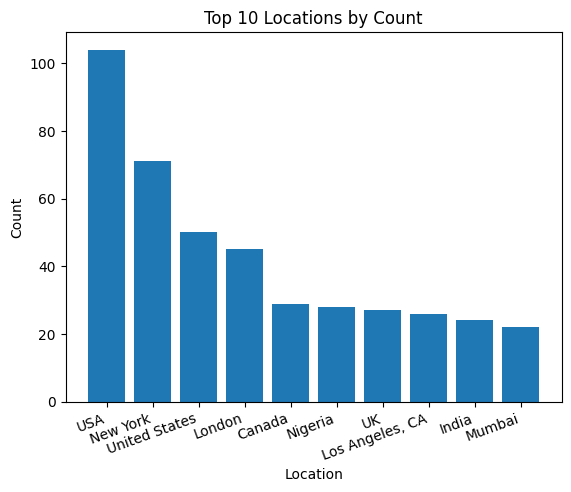

In [43]:
plt.bar(top_10_locations.index.tolist(), top_10_locations.values.tolist() )
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Locations by Count')
plt.show()

Text length

[69, 38, 133, 65, 88, 110, 95, 59, 79, 52, 43, 129, 76, 39, 56, 14, 13, 16, 17, 28, 22, 17, 11, 21, 8, 30, 21, 18, 9, 18, 8, 55, 67, 82, 34, 76, 122, 55, 140, 22, 114, 61, 120, 44, 92, 96, 97, 63, 114, 138, 73, 75, 134, 95, 130, 135, 97, 124, 119, 138, 85, 135, 98, 138, 80, 76, 85, 140, 98, 123, 129, 139, 139, 35, 90, 90, 67, 67, 95, 91, 142, 98, 80, 132, 79, 136, 67, 142, 128, 47, 46, 57, 93, 79, 49, 138, 138, 136, 53, 97, 124, 139, 49, 110, 138, 73, 138, 53, 125, 69, 83, 60, 109, 34, 138, 138, 138, 54, 138, 138, 139, 123, 136, 72, 130, 128, 132, 110, 135, 61, 27, 34, 114, 101, 78, 136, 136, 136, 80, 136, 104, 110, 75, 84, 135, 97, 140, 136, 95, 71, 126, 136, 126, 87, 83, 70, 138, 80, 136, 136, 129, 136, 75, 112, 136, 26, 68, 104, 87, 62, 136, 116, 110, 138, 106, 85, 136, 87, 103, 89, 124, 72, 107, 110, 34, 83, 103, 73, 121, 109, 110, 87, 103, 103, 133, 66, 96, 110, 47, 102, 97, 110, 110, 98, 98, 64, 120, 110, 69, 101, 110, 43, 110, 127, 43, 105, 82, 90, 136, 24, 136, 94, 89, 125, 106

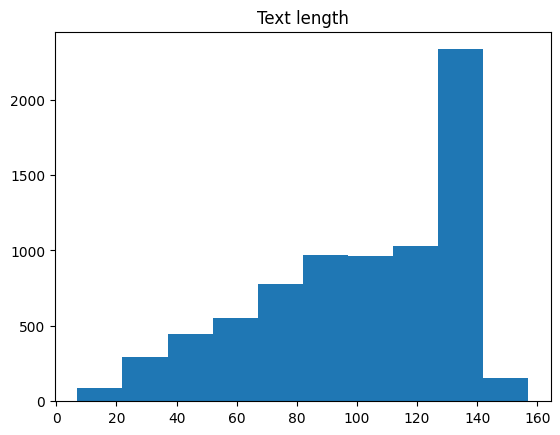

In [50]:
text_len = [len(txt) for txt in train_df['text']]
print(text_len)

plt.hist(text_len)
plt.title('Text length')
plt.show()

Text word count

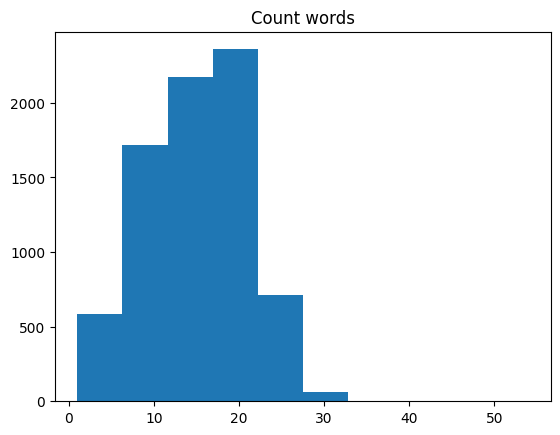

In [51]:
count_words = [len(txt.split(' ')) for txt in train_df['text']]

plt.hist(count_words)
plt.title('Count words')
plt.show()

EDA conclusions:

The 'text' and 'target' columns do not have null values, now we only need to do some preprocessing of the text data, to reduce some noise.

For example, we can delete some stop words.

TODO...

## Preprocessing: Vectorize the text data

In [12]:
# Building vectors
count_vectorizer = feature_extraction.text.CountVectorizer()

# get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [11]:
import sklearn
sklearn.__version__

'1.6.1'

In [13]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [62]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

# For test data, we use `transform` instead of `fit_transform`, 
# because we don't want to embed the words from the test dataset, only
# preprocess the test text for prediction purpose
test_vectors = count_vectorizer.transform(test_df["text"])

## Baseline

Use a standard `RidgeClassifier` as baseline model, which is a linear regression model.

In [15]:
clf = linear_model.RidgeClassifier()

In [ ]:
# Evaluate a score by cross validation
# cv=3 means 3-fold
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59453669, 0.5642787 , 0.64082434])

In [17]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

Apply the model to predict test data.

In [18]:
clf.predict(test_vectors)

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

## More serious models

### LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               11144192  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,152,513
Trainable params: 11,152,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [======================

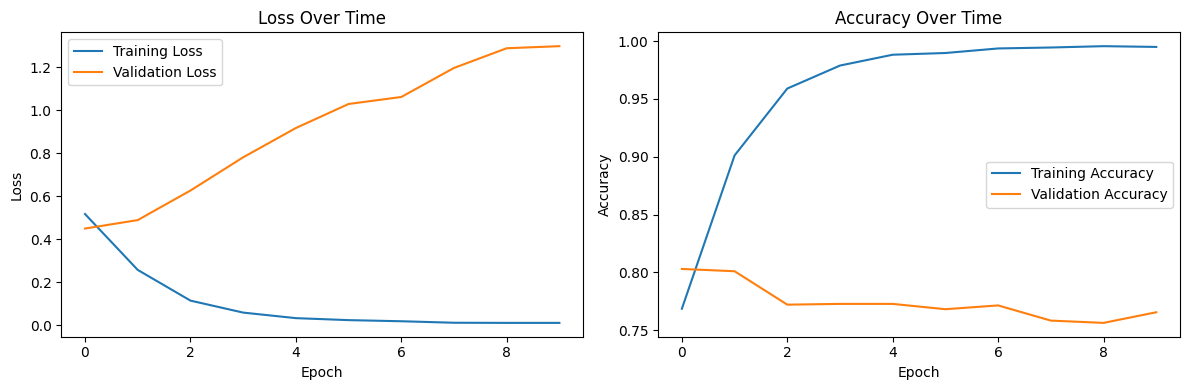

In [63]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
train_vectors = train_vectors.todense()
train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

model = Sequential()

# Add LSTM layers
model.add(LSTM(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: , {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# visulization
plt.figure(figsize=(12, 4))

# render loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# render accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
print("train_vectors shape:", train_vectors.shape)
print("train_vectors type:", type(train_vectors))

train_vectors shape: (7613, 21637)
train_vectors type: <class 'scipy.sparse._csr.csr_matrix'>


We achieved `76.6%` validation accuracy with the LSTM model, not too bad!